In [26]:
import numpy as np
from numpy import random
from sklearn import metrics
import matplotlib.pyplot as plt
from pyod.models.ocsvm import OCSVM
from scipy.linalg import eigh
from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784', as_frame=False)

#X, y = mnist.data, mnist.target

#X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

#rom ucimlrepo import fetch_ucirepo

# fetch dataset
#breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
#X = breast_cancer_wisconsin_diagnostic.data.features
#y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
#print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
#print(breast_cancer_wisconsin_diagnostic.variables)

methods = ['kPCA','PCA','ParzenWindow','OCSVM']

# Util Function

In [27]:
def param_heatmap(method,fig,ax,xparam,yparam,mesh,xlabel,ylabel,bestx,besty,log=False):

    x, y = np.meshgrid(xparam,yparam)
    z = mesh#-np.log(np.abs(1-(mesh)+1e-8)) #scaling to emphasize upper range differences in AUC
    c = ax.pcolormesh(x, y, z, cmap='viridis', vmin=z.min(), vmax=z.max())
    ax.set_title(method)
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    if log:
        ax.set_xscale('log')
    cbar =fig.colorbar(c,  ticks=[z.min(), np.median(z),z.max()],ax=ax)
    ax.scatter(bestx,besty,marker = "*",s = 10,color = 'r')
    #cbar.ax.set_yticklabels([round(1-np.exp(-z.min()),3), 0.5, round(1-np.exp(-z.max()),3)])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

In [28]:
def param_scatter(method,fig,ax,xparam,aucs,xlabel,log=False):
    x = xparam
    y = aucs
    c = ax.scatter(x,y)
    ax.set_title(method)
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('AUC')
    if log:
        ax.set_xscale('log')

In [29]:
def decision_boundary_plot(x_train, x_test, y_test, models,Method):
  colors = ['g','r','b','m']
  #fig, axs = plt.subplots(2,2,figsize=(10,10))
  fig, axs = plt.subplots(1,1)
  an_idx = np.where(y_test == 1)
  bg_idx = np.where(y_test == 0)

  xsteps = 50
  ysteps = 50
  xmin = np.min(x_train[:,0])*1.1
  ymin = np.min(x_train[:,1])*1.1
  xmax = np.max(x_train[:,0])*1.1
  ymax = np.max(x_train[:,1])*1.1


  xx,yy = np.meshgrid(np.linspace(xmin,xmax,xsteps), np.linspace(ymin,ymax,ysteps))
  grid_dims = xx.shape
  xx_f = np.expand_dims(xx.flatten(),axis=1)
  yy_f = np.expand_dims(yy.flatten(),axis=1)
  grid_list = np.concatenate((xx_f,yy_f),axis = 1)


  axs_ = np.reshape(axs,len(models))
  for i in range(len(models)):
    axs_[i].scatter(x_train[:,0], x_train[:,1],s=10,label = None, color = 'k',marker='s', edgecolors='k',alpha = 0.8)
    axs_[i].scatter(x_test[bg_idx,0], x_test[bg_idx,1],s=10,label = None, color = 'b',marker='s', edgecolors='b',alpha = 0.5)
    axs_[i].scatter(x_test[an_idx,0],x_test[an_idx,1], s=10,label = None, color = 'r',marker='s', edgecolors='r',alpha = 0.5)

    grid_errs = np.reshape(np.expand_dims(models[i].decision_function(grid_list),axis=1),grid_dims)

    bgval_idx = np.where(y_val == 0)
    scores = models[i].decision_function(x_val)
    fixed = np.max(scores[bgval_idx])
    cntr1 = axs_[i].contour(xx,yy,grid_errs,[fixed],colors=colors[i])
    #axs_[i].axis('off')
    axs_[i].set_xlim(xmin,xmax)
    axs_[i].set_ylim(ymin,ymax)
    axs_[i].set_title(Method)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)


In [30]:
def ROC_curve(y_test, scores, key):
  methods = ['kPCA','PCA','ParzenWindow','OCSVM']
  fig, ax = plt.subplots(figsize=(7,7))
  colors = ['g','r','b','m']
  for i in range(len(methods)):
      fpr,tpr,_ = metrics.roc_curve(y_test,scores[i],drop_intermediate = False)
      tpr[1] = 0
      if test_aucs[i] == 0.5:
          fpr = np.linspace(0,1,100)
          tpr = fpr
      ax.plot(fpr,tpr, color = colors[i], marker='o',label = methods[i],ms=2)
  x=np.linspace(0,1,100)
  y = x
  ax.plot(x,y,ls = "--",label='random')
  ax.set_xlim([1e-4,1])
  ax.legend()
  ax.set_title(key+' ROC')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_xscale('log')

In [31]:
def check_d(edge,point,thresh):
    n = edge.shape[0]
    p_exp = np.repeat(np.expand_dims(point,axis=0),n,axis=0)
    diff = edge - p_exp
    dist = np.sqrt(diff[:,0]*diff[:,0] + diff[:,1]*diff[:,1])
    if np.min(dist) > thresh:
        return True
    else:
        return False


# **Functions to Generate required datasets**


In [32]:
def Circle_dataset():
  ## Generate Circle dataset
  n_bg_train = 600
  n_bg_test = n_bg_train

  n1 = n_bg_test + n_bg_train #n_background
  n2 = 600 #n_anomalies

  data = np.zeros((n2+n1,2))

  buffer = 0.025
  a2=0.35
  b1=0.75
  b2=0.9

  pi = np.pi
  Area_a = pi*(a2*a2)
  Area_b = pi*(b2*b2 - b1*b1)
  prob_in_b = Area_b/(Area_b+Area_a)

  for i in range(n2+n1):
      if i < n2:
          r = (a2)/2
          while (r < a2+buffer) or (r > b1-buffer and r < b2+buffer):
              x = random.uniform(-1.2,1.2)
              y = random.uniform(-1.2,1.2)
              r = np.sqrt(x*x+y*y)
          data_i = np.array([x,y])


      if i > n2:
          roll = random.uniform(0,1)
          if roll > prob_in_b:
              r = random.uniform(0,a2)
          else:
              r = random.uniform(b1,b2)

          theta = random.uniform(0,2*np.pi)
          data_i = np.array([r*np.cos(theta),r*np.sin(theta)])

      data[i,:] = data_i


  labels = np.zeros((n1+n2))
  labels[:n2] = 1

  an_idx = np.where(labels == 1)[0]
  bg_idx = np.where(labels == 0)[0]

  x_train = data[bg_idx[:n_bg_train]]
  x_bg_test = data[bg_idx[n_bg_train:]]
  x_an_test = data[an_idx]

  y_test = np.zeros((x_bg_test.shape[0]+x_an_test.shape[0]))
  y_test[x_bg_test.shape[0]:]=1
  x_test = np.vstack((x_bg_test,x_an_test))

  test_size = x_test.shape[0]
  idx = np.random.randint(0,test_size, int(test_size/2))
  x_val = x_test[idx]
  y_val = y_test[idx]
  x_test = x_test[~idx]
  y_test = y_test[~idx]
  return  x_train, x_val, y_val, x_test, y_test

In [33]:
def Roll_dataset():
  n_bg_train = 400
  n_bg_test = n_bg_train

  n1 = n_bg_test + n_bg_train#n_background
  n2 = 300#n_anomalies

  data = np.zeros((n2+n1,2))
  edge = np.zeros((4*n1,2))
  labels = np.zeros((n1+n2))

  buffer = 0.6
  a=0
  b=0.7
  c=1.25
  width = 0.5
  loops = 2.5

  for i in range(n2+n1):
      thetas = np.linspace(0,loops*2*np.pi,n1)
      if i < n1:

          theta = thetas[i]

          r = (a+b*theta)
          x = r*np.cos(theta)+(2*random.randint(0, 1)-1)*random.uniform(-width,width)
          y = r*np.sin(theta)+(2*random.randint(0, 1)-1)*random.uniform(-width,width)#

          data_i = np.array([x,y])
          data[i,:] = data_i
          labels[i] = 0

          bg_data = data[:n1]
          max_Data = np.max(bg_data)
          min_Data = np.min(bg_data)




      if i > n1:
          go = True

          while go:
              x = random.uniform(min_Data,max_Data)
              y = random.uniform(min_Data,max_Data)
              if check_d(bg_data,np.array([x,y]),buffer):
                  go = False

          data_i = np.array([x,y])
          data[i,:] = data_i
          labels[i] = 1

  #import matplotlib.pyplot as plt
  #fig, ax = plt.subplots()
  #ax.scatter(data[:,0], data[:,1],s=10,label = None, color = 'k',marker='s', edgecolors='k',alpha = 0.8)
  #ax.scatter(edge[:,0], edge[:,1],s=10,label = None, color = 'b',marker='s', edgecolors='b',alpha = 0.5)

  shuff = np.random.permutation(n1+n2)
  data = data[shuff]
  labels = labels[shuff]

  an_idx = np.where(labels == 1)[0]
  bg_idx = np.where(labels == 0)[0]

  x_train = data[bg_idx[:n_bg_train]]
  x_bg_test = data[bg_idx[n_bg_train:]]
  x_an_test = data[an_idx]

  y_test = np.zeros((x_bg_test.shape[0]+x_an_test.shape[0]))
  y_test[x_bg_test.shape[0]:]=1
  x_test = np.vstack((x_bg_test,x_an_test))

  return  x_train, x_val, y_val, x_test, y_test


In [34]:
def Digit0_dataset():
  from scipy.ndimage.filters import gaussian_filter
  from skimage.transform import resize
  from keras.datasets import mnist

  background_digit = 0
  anomaly_digits = [1,2,3,4,5,6,7,8,9]
  new_size = 8
  n_bg_train = 2000
  n_bg_test = 980
  n_an_test = 109

  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  data = np.vstack((x_train,x_test))
  labels = np.concatenate((y_train,y_test))

  data = data.astype('float32') / 255
  bg_idx = np.where(labels == background_digit)


  x_train = data[bg_idx][:n_bg_train]
  x_bg_test = data[bg_idx][n_bg_train:n_bg_train+n_bg_test]

  an_idx = []
  for d in anomaly_digits:
      idx = np.where(labels == d)
      an_idx.append(idx)

  an_test = []
  for d in range(len(anomaly_digits)):
      idx = an_idx[d][0][:n_an_test]
      an_test.append(data[idx])
  x_an_test = np.vstack(an_test)

  y_test = np.zeros((x_bg_test.shape[0]+x_an_test.shape[0]))
  y_test[x_bg_test.shape[0]:]=1
  x_test = np.vstack((x_bg_test,x_an_test))

  #blur and resize and flatten
  x_train = gaussian_filter(x_train, sigma=1)#sigma not specified in paper
  x_test = gaussian_filter(x_test, sigma=1)#sigma not specified in paper
  x_train = resize(x_train, (x_train.shape[0],new_size,new_size))
  x_test = resize(x_test, (x_test.shape[0],new_size,new_size))

  #flatten
  x_train = np.reshape(x_train, [-1, new_size*new_size])
  x_test = np.reshape(x_test, [-1, new_size*new_size])
  return  x_train, x_val, y_val, x_test, y_test


# KPCA

In [35]:
class kPCA:
    """
    Parameters
    ----------
    kernel : string, optional (default='rbf')
         Specifies the kernel type to be used in the algorithm.
         It must be one of 'poly' or 'rbf'
         If none is given, 'rbf' will be used.

    sigma : float, optional (default=1)
        Kernel coefficient for 'rbf'

    order : int, optional (default=3)
        Kernel degree for 'poly'

    q : int, optional (default='same')
        number of retained eigenvectors (alphas) for the reconstruction error
        If q is 'auto' then n_features will be used instead. For a 'linear
        kernel this will result in zero reconstruction error

    sample_pct : float, optional (default: 1.0)
        What percentage of the data to use to determine the principle components

    batch_size : int, optional (default: 500)
        The number of examples per batch during testing

    contamination : float in (0., 0.5), optional (default=0.1)
        The amount of contamination of the data set,
        i.e. the proportion of outliers in the data set. Used when fitting to
        define the threshold on the decision function.

    verbose : bool, (default: False)
        Prints out runtime and feedback

    useAll : bool, (default = True )
        #Use the full dataset for the evaluation projection?

    Attributes
    ----------

    model_X_S : numpy array of shape (n_sub,d_features)
        sample of X used for calulating alphas, typically the full sample is \
        used so that X_S = X. Sampling set by sample_pct

    model_K_mat : numpy array of shape (n_sub,sub)
        uncentered gram matrix after training

    model_alphas : numpy array of shape (n_samples, q)
        retained eigen values after training

    decision_scores_ : numpy array of shape (n_samples,)
        The outlier scores of the training data.
        The higher, the more abnormal. Outliers tend to have higher scores.
        This value is available once the detector is fitted.

    threshold_ : float
        The threshold is based on ``contamination``. It is the
        ``n_samples * contamination`` most abnormal samples in
        ``decision_scores_``. The threshold is calculated for generating
        binary outlier labels.

    labels_ : int, either 0 or 1
        The binary labels of the training data. 0 stands for inliers
        and 1 for outliers/anomalies. It is generated by applying
        ``threshold_`` on ``decision_scores_``.
    """

    def __init__(self, order = 3, q = 'same', sigma = 1.0,
                 sample_pct = 1.0, shrinking=True, batch_size = 500,
                 contamination = 0.1, verbose=False):
        self.sigma = sigma
        self.gamma = 1/2/sigma/sigma
        self.order = order
        self.q = q
        self.sample_pct = sample_pct
        self.batch_size = batch_size
        self.contamination = contamination
        self.verbose = verbose


    def subsample_data(self,X, sample_pct = None):
        """Returns X_S a random subsample of X".

        Parameters
        ----------
        X : numpy array of shape (n_samples, d_features)
            The input samples.
        sample_pct: float, percentage (0,1) to sample from X
        """

        n_sub = int(sample_pct * X.shape[0])

        sample_idx = np.random.permutation(n_sub)

        X_s = X[sample_idx]

        return X_s


    def gramMatrix(self,X, X_S, params = None):
        """Returns the (n x n) gram matrix based on the kernel.

        Parameters
        ----------
        X : numpy array of shape (n_samples, d_features)
            The input samples.

        kernel: string,  {'rbf, 'poly'}
            kernel function to use options

        params: float, kernel parameter, defaults to sigma or order if None
        """


        a = np.expand_dims(np.diag(X_S.dot(X_S.T)),axis = 1).dot(np.ones((1, X.shape[0])))
        b = np.ones((X_S.shape[0],1)).dot(np.expand_dims(np.diag(X.dot(X.T)),axis = 0))

        sqrd_dists = a + b - 2*X_S.dot(X.T)

        # RBF
        params = self.gamma
        K = np.exp(-params*sqrd_dists)

        # Poly
        #params = self.order
        #K = np.power((sqrd_dists +1),params)
        return K



    def eigenDecomp_gramMatrix(self, K_centered):
        """Returns the leading q number of eigenvectors from the eigendecomposition
        of the centered gram matrix

        Parameters
        ----------
        K : numpy array of shape (n_samples,n_samples)
            centered gram matrix

        numev: int, number of eigenvectors (alphas) to retain
        """

        numev = self.q #use class default if none is specified

        w, v = eigh(K_centered)
        w = w.reshape(-1,1)
        w = np.flipud(w)
        v = np.fliplr(v)
        alphas = v[:,:numev]

        #Each column is an eigen vector
        lambdas = w[:numev]
        #from biggest to smallest
        alphs = alphas*np.squeeze(1/np.sqrt(lambdas))



        return alphs


    def calc_reconstructionErrors(self, X,  X_S, K_mat, alphs):
        """Returns the reconstruction error projecting onto alphas.

        Parameters
        ----------
        X : numpy array of shape (n_samples, d_features)
            The input samples.

        alphs: numpy array of shape (n_samples, q)
            eigenvectors of centered gram matrix


        X_S : numpy array of shape (n_subsamples, d_features), optional (default=None)
            Subsampling of the data. If none, the full kernel is used for projection
        """



        n_samples, d_features = X.shape
        n_sub = X_S.shape[0]

        numev = alphs.shape[1]


        #helper calcs
        Krow = K_mat.sum(axis = 0)/n_sub #not normed!
        Ksum = (Krow).sum()/n_sub
        sumalphs = np.ones(X_S.shape[0]).dot(alphs)


        reconstruction_errs = np.zeros(n_samples)

        for block_i in (range(0,n_samples,self.batch_size)):
            if self.verbose:
                percentDone = 100 * (block_i)/ n_samples;
                print(f"Evaluating training set... {percentDone:.2f}%", end='\r')


            X_block = X[block_i:block_i+self.batch_size,:]
            n_block = X_block.shape[0]

            k_L = self.gramMatrix(X_block, X_S)


            f_L = np.dot(k_L.T,alphs) - (sumalphs*np.ones((n_block,numev)) * \
                         np.expand_dims((np.sum(k_L,axis=0).T/n_sub - Ksum),axis=1)) \
                         -  np.ones((n_block, numev))*np.dot(Krow,alphs)


            errs_block = ( 1 - (2*np.sum(k_L,axis = 0)/n_sub).T + Ksum ) \
                    - np.diag(np.dot(f_L,f_L.T))

            reconstruction_errs[block_i:block_i+self.batch_size] = errs_block


        if self.verbose:
            print(f"Evaluating training set... {100:.2f}%")
        return  reconstruction_errs

    def threshold(self,scores,contamination):
        """Fit detector. y is optional for unsupervised methods.

        Parameters
        ----------
        scores : numpy array of shape (n_samples, d_features)
        The input samples.

        contamination : float in (0., 0.5), optional (default=0.1)
            The amount of contamination of the data set,
            i.e. the proportion of outliers in the data set. Used when fitting to
            define the threshold on the decision function.
        """
        threshold_ = np.quantile(scores,1-contamination)
        labels = np.ones(scores.shape[0])
        labels[scores < threshold_] = 0

        self.threshold_ = threshold_
        return labels



    def fit(self, X, y=None):
        """Fit detector. y is optional for unsupervised methods.

        Parameters
        ----------
        X : numpy array of shape (n_samples, d_features)
        The input samples.

        y : numpy array of shape (n_samples,), optional (default=None)
        The ground truth of the input samples (labels).
        """

        n_samples, d_features = np.shape(X)
        self.d_features = d_features

        if int(self.sample_pct * X.shape[0]) < self.d_features:
            self.n_sub = max(self.q,self.d_features)
            self.sample_pct = (self.n_sub/X.shape[0])+1e-3


        if self.sample_pct < 1:
            X_S = self.subsample_data(X)
        else:
            X_S = X


        n_sub = X_S.shape[0]

        K_mat = self.gramMatrix(X_S,X_S)


        # symmetrize to correct minor numerical errors
        K_mat = (K_mat + K_mat.T) / 2

        one_n = np.ones((n_sub,n_sub)) / n_sub
        K_centered = K_mat - one_n.dot(K_mat - K_mat.dot(one_n)) + one_n.dot(K_mat).dot(one_n)

        if self.verbose:
            print("Computed gram matrix")

        alphs = self.eigenDecomp_gramMatrix(K_centered)

        if self.verbose:
                print("Computed alphas","\n")

        self.model_alphas = alphs
        self.model_X_S = X_S
        self.model_K_mat = K_mat

        reconstruction_errs = self.calc_reconstructionErrors(X,  X_S, K_mat, alphs)

        self.decision_scores_ = reconstruction_errs

        self.labels_ = self.threshold(self.decision_scores_,self.contamination)

        return self



    def decision_function(self, X_test):
        """predict anomaly scores (reconstruction error) using model \
        gram matrix and alphas

        Parameters
        ----------
        X_test : numpy array of shape (n_test_samples, d_features)
        The test samples.
        """

        if X_test.ndim == 1: # correct dimension if a single example is given
            X_test = np.expand_dims(X_test,axis = 0)

        scores = self.calc_reconstructionErrors(X_test,  self.model_X_S, self.model_K_mat, self.model_alphas)

        return scores


    def predict(self,X_test,threshold = None):
        """predict anomaly label (reconstruction error) using model \
        gram matrix and alphas

        Parameters
        ----------
        X_test : numpy array of shape (n_test_samples, d_features)
        The test samples.

        threshold: float, optional, default to threshold calculated by .fit()
        """

        if X_test.ndim == 1: # correct dimension if a single example is given
            X_test = np.expand_dims(X_test,axis = 0)

        if threshold == None:
            threshold = self.threshold_

        scores = self.predict(X_test)

        labels = np.ones(scores.shape[0])
        labels[scores < threshold] = 0

        return labels



# PCA

In [36]:
class PCA:
    def __init__(self,q):
        self.q = q

    def mean_center(self,data):
        """
        mean center the data for linear PCA
        """
        mean = np.repeat(np.expand_dims(np.mean(data,axis=0),axis=0),data.shape[0],axis=0)
        data = (data-mean)
        return(data)

    def check_data(self,data):
        n_samples, d_features = np.shape(data)

        self.d_features = d_features
        self.n_samples = n_samples

        data = self.mean_center(data)

        return data


    def fit(self,data):
        """Fit detector. y is optional for unsupervised methods.

        Parameters
        ----------
        X : numpy array of shape (n_samples, d_features)
        The input samples.

        y : numpy array of shape (n_samples,), optional (default=None)
        The ground truth of the input samples (labels).
        """

        data = self.check_data(data)

        self.Covar_mat = (1/self.n_samples)*data.T.dot(data)

        #do eigendcomposition
        values, vectors = np.linalg.eig(self.Covar_mat)

        #sort in descending order
        idx = np.argsort(-np.real(values))
        self.variances = values[idx]
        self.eigenvectors = vectors[:,idx]


    def decision_function(self, data):
        """predict anomaly scores (reconstruction error)

        Parameters
        ----------
        data : numpy array of shape (n_test_samples, d_features)
        The test samples.
        """

        data = self.check_data(data)

        if data.ndim == 1: # correct dimension if a single example is given
            data = np.expand_dims(data,axis = 0)

        new_data = (self.eigenvectors.T.dot(data.T)).T
        r_data = (self.eigenvectors[:,:self.q].T.dot(data.T)).T

        scores = new_data.dot(new_data.T).sum(axis=0) - r_data.dot(r_data.T).sum(axis=0)

        return scores

# Circle dataset evaluation

In [37]:
num_search = 10 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

x_train, x_val, y_val, x_test, y_test = Circle_dataset()

dataset:Cricle method:{ kPCA } best params: {q: 23.0 sigma: 0.2154 } val auc: 0.9999   test auc: 0.9994


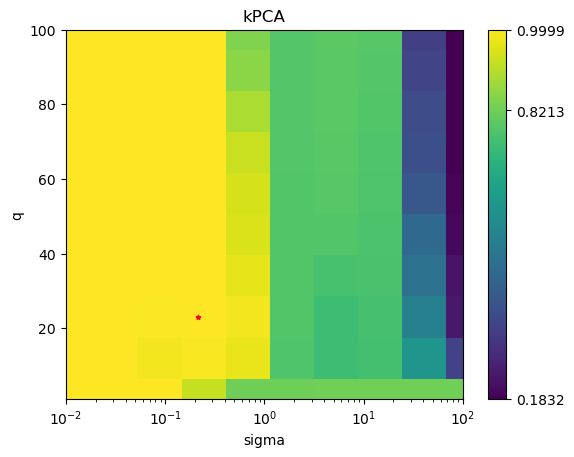

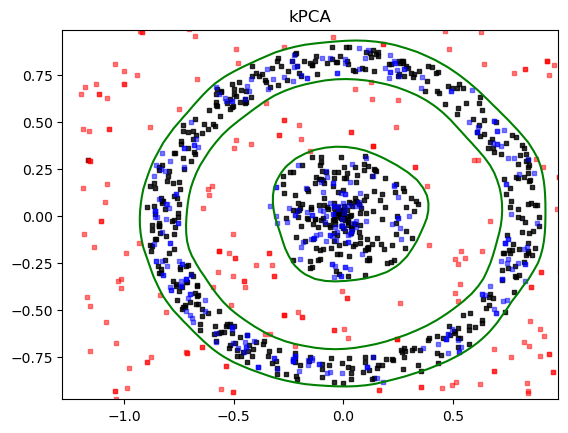

In [38]:
## KPCA
fig, axs = plt.subplots(1,1)
num_params = num_search
sigmas = np.logspace(-2,2,num_params)
maxq = 100
qs = np.linspace(1,maxq,num_params,dtype = 'int')

gridsearch = np.zeros((num_params*num_params,3)) #sigma, q, auc for each run
mesh = np.zeros((num_params,num_params))

#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    j = 0
    for q in qs:
        model = kPCA(q = q, sigma = sigma)
        model.fit(x_train)
        val_scores = model.decision_function(x_val)
        auc = metrics.roc_auc_score(y_val,val_scores)
        gridsearch[run,:]= np.asarray([sigma,q,auc])
        mesh[j,i]=auc
        run += 1
        j += 1
    i += 1

best_idx = np.argmax(gridsearch[:,2])
val_auc = np.max(gridsearch[:,2])
best_sigma = gridsearch[best_idx,0]
best_q = gridsearch[best_idx,1]

param_heatmap(methods[0],fig,axs,sigmas,qs,mesh,"sigma",'q',best_sigma,best_q,log=True)

model = kPCA(q = int(best_q), sigma = best_sigma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
print('dataset:Cricle method:{',methods[0],'} best params:',  '{q:',best_q,'sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
models.append(model)

decision_boundary_plot(x_train, x_test, y_test, [model],methods[0])



dataset:{Circle} method:{ PCA } best params: {q: 1.0 } val auc: 0.5   test auc: 0.5185


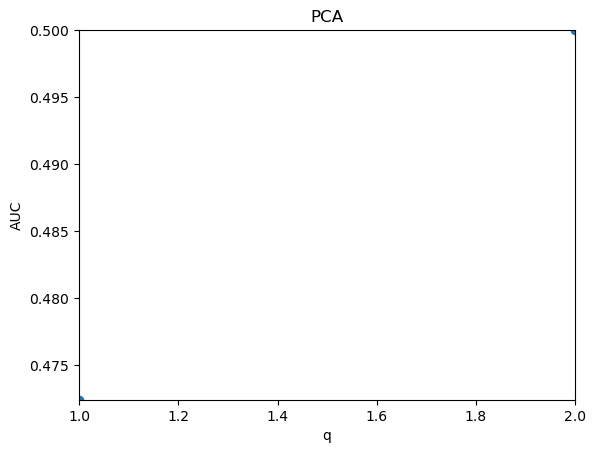

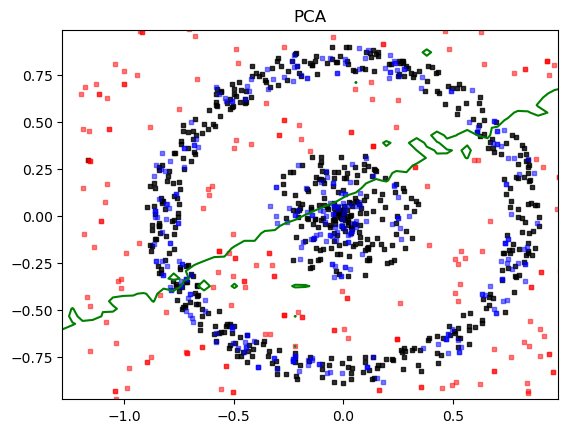

In [39]:
## PCA
fig, axs = plt.subplots(1,1)

num_params = x_train.shape[1]
qs = np.linspace(1,x_train.shape[1],num_params,dtype = 'int')

gridsearch = np.zeros((num_params,2))

#perform gridsearch
run = 0


for q in qs:
    model = PCA(q)
    model.fit(x_train)
    val_scores = model.decision_function(x_val)
    auc = metrics.roc_auc_score(y_val,val_scores)
    gridsearch[run,:]= np.asarray([q,auc])
    run += 1

best_idx = np.argmax(gridsearch[:,1])
val_auc = np.max(gridsearch[:,1])
best_q = gridsearch[best_idx,0]

param_scatter(methods[1],fig,axs,gridsearch[:,0],gridsearch[:,1],'q',log=False)

if best_q == x_train.shape[1]:
    best_q -= 1 #don't produce only zeros

model = PCA(q = int(best_q))
model.fit(x_train)
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
print('dataset:{Circle} method:{',methods[1],'} best params:', '{q:',best_q,'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
models.append(model)
#plt.subplots_adjust(hspace=0.5, wspace=0.5)
#st = fig.suptitle('Circle', fontsize="x-large")
decision_boundary_plot(x_train, x_test, y_test, [model],methods[1])



dataset:{Circle} method:{ ParzenWindow } best params: {sigma: 0.0278 } val auc: 0.9993   test auc: 0.9966


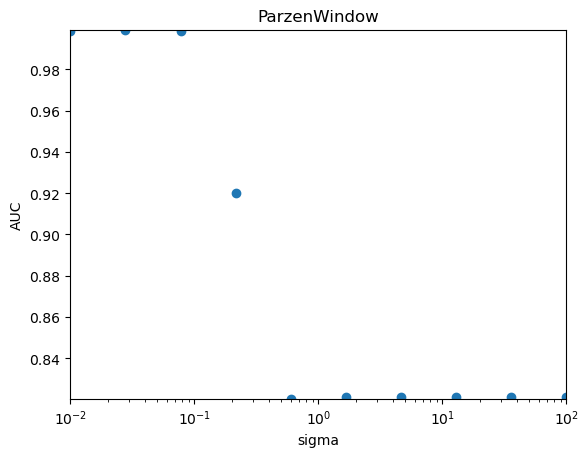

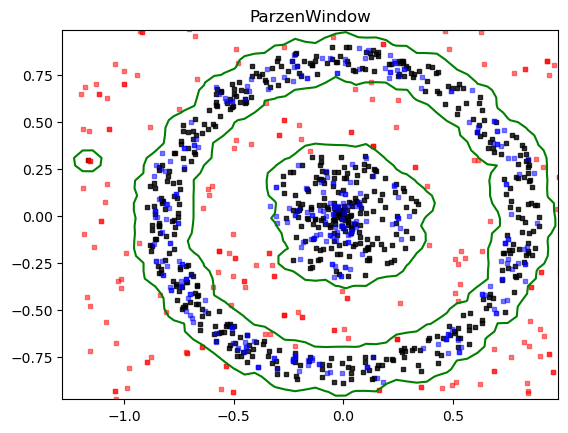

In [40]:
# ParzenWindow
fig, axs = plt.subplots(1,1)
#equivalent to kPCA with q = 0, up to a multiplicative constant
num_params = num_search
sigmas = np.logspace(-2,2,num_params)

gridsearch = np.zeros((num_params,2))

#perform gridsearch
run = 0
for sigma in sigmas:
    model = kPCA(q = 0,sigma = sigma)
    model.fit(x_train)
    val_scores = model.decision_function(x_val)
    auc = metrics.roc_auc_score(y_val,val_scores)
    gridsearch[run,:]= np.asarray([sigma,auc])
    run += 1

best_idx = np.argmax(gridsearch[:,1])
val_auc = np.max(gridsearch[:,1])
best_sigma = gridsearch[best_idx,0]

param_scatter(methods[2],fig,axs,gridsearch[:,0],gridsearch[:,1],'sigma',log=True)


model = kPCA(q = 0, sigma = (best_sigma))
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
print('dataset:{Circle} method:{',methods[2],'} best params:',  '{sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
models.append(model)
decision_boundary_plot(x_train, x_test, y_test, [model],methods[2])


dataset:{Circle} method:{ OCSVM } best params: {nu: 0.01 sigma: 0.0774 } val auc: 0.9999   test auc: 0.9979


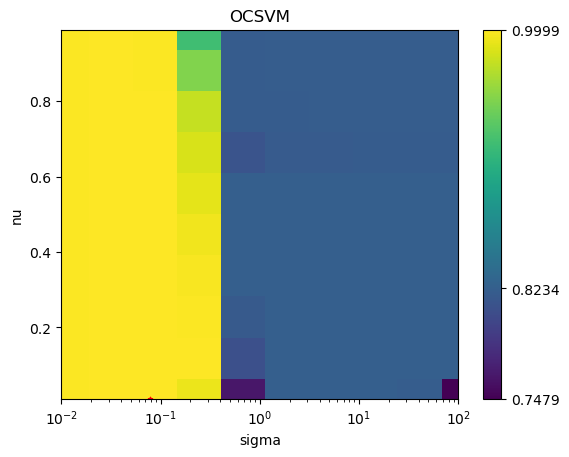

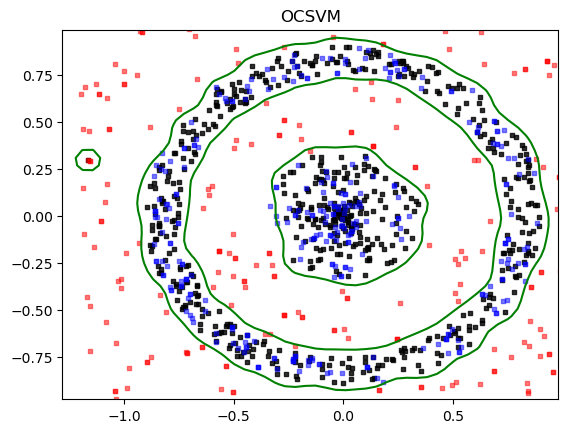

In [41]:
# OCSVM
fig, axs = plt.subplots(1,1)
num_params = num_search
sigmas = np.logspace(-2,2,num_params)
nus = np.linspace(0.01,0.99,num_params)

gridsearch = np.zeros((num_params*num_params,3)) #sigma rows, q, cols
mesh = np.zeros((num_params,num_params))
#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    j = 0
    for nu in nus:
        gamma = 0.5/(sigma*sigma)
        model = OCSVM(nu = nu, gamma = gamma)
        model.fit(x_train)
        val_scores = model.decision_function(x_val)
        auc = metrics.roc_auc_score(y_val,val_scores)
        gridsearch[run,:]= np.asarray([sigma,nu,auc])
        mesh[j,i]=auc
        run += 1
        j += 1
    i += 1

best_idx = np.argmax(gridsearch[:,2])
val_auc = np.max(gridsearch[:,2])
best_sigma = gridsearch[best_idx,0]
best_nu = gridsearch[best_idx,1]

param_heatmap(methods[3],fig,axs,sigmas,nus,mesh,'sigma','nu',best_sigma,best_nu,log=True)

gamma = 0.5/(best_sigma*best_sigma)
model = OCSVM(nu = best_nu, gamma = gamma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
print('dataset:{Circle} method:{',methods[3],'} best params:',  '{nu:',round(best_nu,4),'sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
models.append(model)
decision_boundary_plot(x_train, x_test, y_test, [model],methods[3])


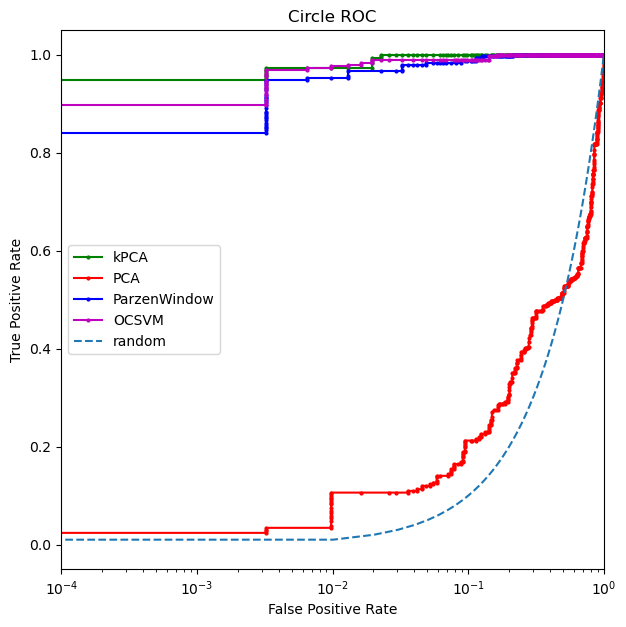

In [42]:
# ROC Curve
ROC_curve(y_test, scores, key='Circle')

# Roll dataset evaluation

In [43]:
num_search = 10 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

x_train, x_val, y_val, x_test, y_test = Roll_dataset()

dataset:Cricle method:{ kPCA } best params: {q: 1.0 sigma: 4.6416 } val auc: 0.8076   test auc: 0.7684


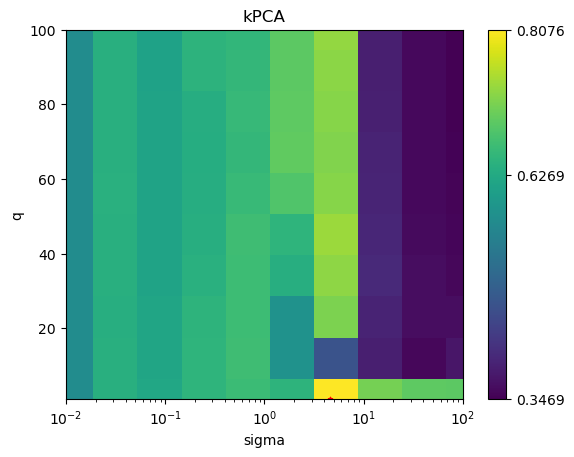

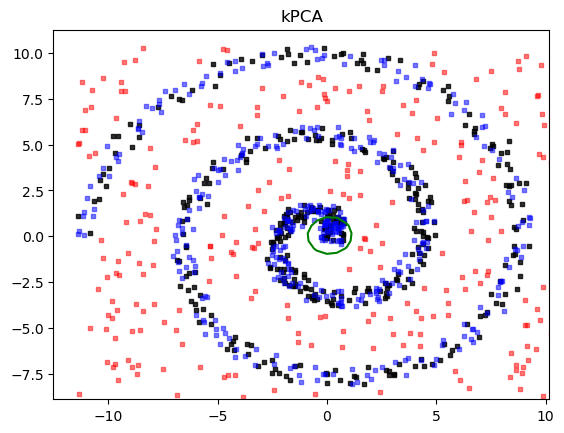

In [44]:
## KPCA
fig, axs = plt.subplots(1,1)
num_params = num_search
sigmas = np.logspace(-2,2,num_params)
maxq = 100
qs = np.linspace(1,maxq,num_params,dtype = 'int')

gridsearch = np.zeros((num_params*num_params,3)) #sigma, q, auc for each run
mesh = np.zeros((num_params,num_params))

#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    j = 0
    for q in qs:
        model = kPCA(q = q, sigma = sigma)
        model.fit(x_train)
        val_scores = model.decision_function(x_val)
        auc = metrics.roc_auc_score(y_val,val_scores)
        gridsearch[run,:]= np.asarray([sigma,q,auc])
        mesh[j,i]=auc
        run += 1
        j += 1
    i += 1

best_idx = np.argmax(gridsearch[:,2])
val_auc = np.max(gridsearch[:,2])
best_sigma = gridsearch[best_idx,0]
best_q = gridsearch[best_idx,1]

param_heatmap(methods[0],fig,axs,sigmas,qs,mesh,"sigma",'q',best_sigma,best_q,log=True)

model = kPCA(q = int(best_q), sigma = best_sigma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
print('dataset:Cricle method:{',methods[0],'} best params:',  '{q:',best_q,'sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
models.append(model)

decision_boundary_plot(x_train, x_test, y_test, [model],methods[0])



dataset:{Circle} method:{ PCA } best params: {q: 1.0 } val auc: 0.5442   test auc: 0.5254


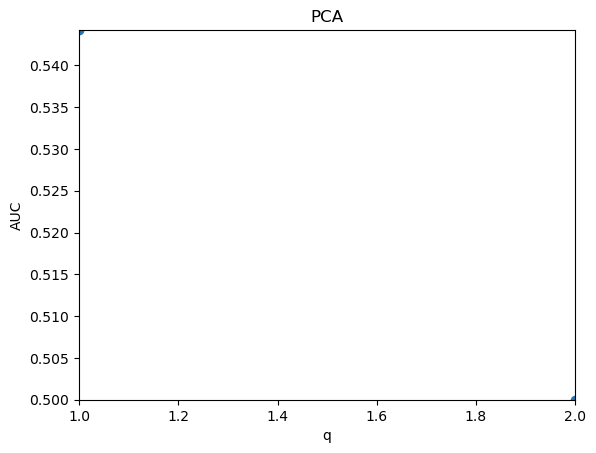

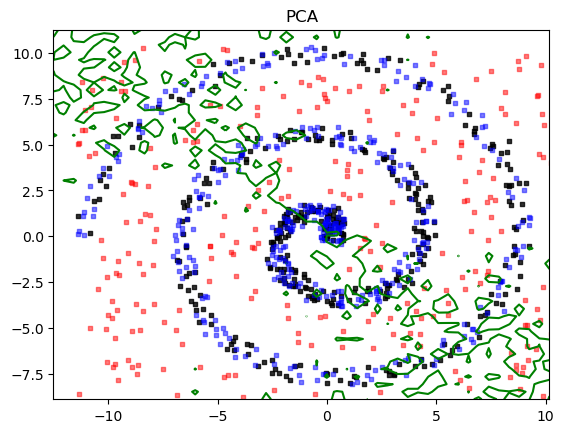

In [45]:
## PCA
fig, axs = plt.subplots(1,1)

num_params = x_train.shape[1]
qs = np.linspace(1,x_train.shape[1],num_params,dtype = 'int')

gridsearch = np.zeros((num_params,2))

#perform gridsearch
run = 0


for q in qs:
    model = PCA(q)
    model.fit(x_train)
    val_scores = model.decision_function(x_val)
    auc = metrics.roc_auc_score(y_val,val_scores)
    gridsearch[run,:]= np.asarray([q,auc])
    run += 1

best_idx = np.argmax(gridsearch[:,1])
val_auc = np.max(gridsearch[:,1])
best_q = gridsearch[best_idx,0]

param_scatter(methods[1],fig,axs,gridsearch[:,0],gridsearch[:,1],'q',log=False)

if best_q == x_train.shape[1]:
    best_q -= 1 #don't produce only zeros

model = PCA(q = int(best_q))
model.fit(x_train)
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
print('dataset:{Circle} method:{',methods[1],'} best params:', '{q:',best_q,'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
models.append(model)
#plt.subplots_adjust(hspace=0.5, wspace=0.5)
#st = fig.suptitle('Circle', fontsize="x-large")
decision_boundary_plot(x_train, x_test, y_test, [model],methods[1])



dataset:{Circle} method:{ ParzenWindow } best params: {sigma: 4.6416 } val auc: 0.8071   test auc: 0.7684


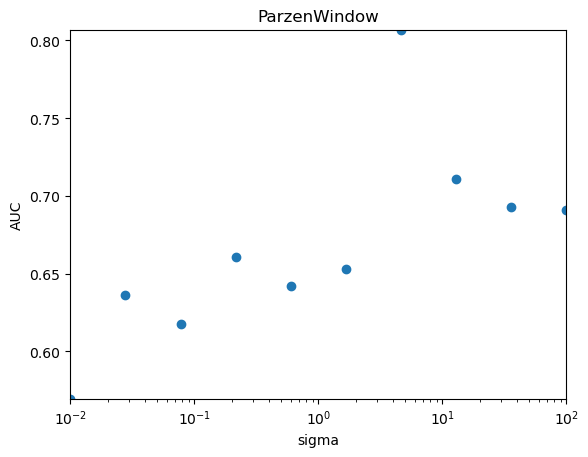

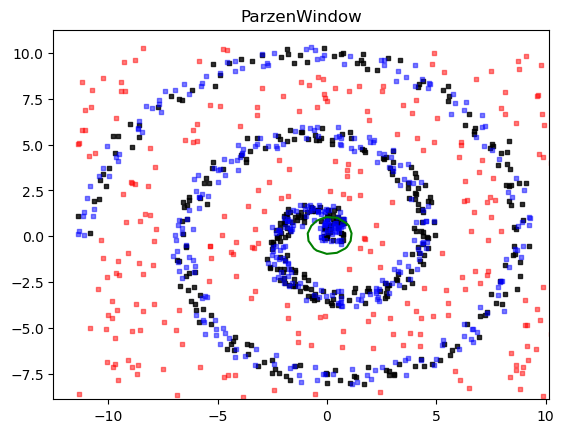

In [46]:
# ParzenWindow
fig, axs = plt.subplots(1,1)
#equivalent to kPCA with q = 0, up to a multiplicative constant
num_params = num_search
sigmas = np.logspace(-2,2,num_params)

gridsearch = np.zeros((num_params,2))

#perform gridsearch
run = 0
for sigma in sigmas:
    model = kPCA(q = 0,sigma = sigma)
    model.fit(x_train)
    val_scores = model.decision_function(x_val)
    auc = metrics.roc_auc_score(y_val,val_scores)
    gridsearch[run,:]= np.asarray([sigma,auc])
    run += 1

best_idx = np.argmax(gridsearch[:,1])
val_auc = np.max(gridsearch[:,1])
best_sigma = gridsearch[best_idx,0]

param_scatter(methods[2],fig,axs,gridsearch[:,0],gridsearch[:,1],'sigma',log=True)


model = kPCA(q = 0, sigma = (best_sigma))
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
print('dataset:{Circle} method:{',methods[2],'} best params:',  '{sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
models.append(model)
decision_boundary_plot(x_train, x_test, y_test, [model],methods[2])


dataset:{Circle} method:{ OCSVM } best params: {nu: 0.99 sigma: 4.6416 } val auc: 0.8061   test auc: 0.7684


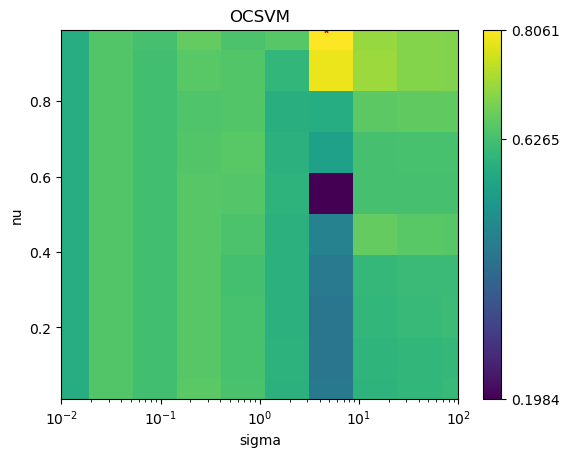

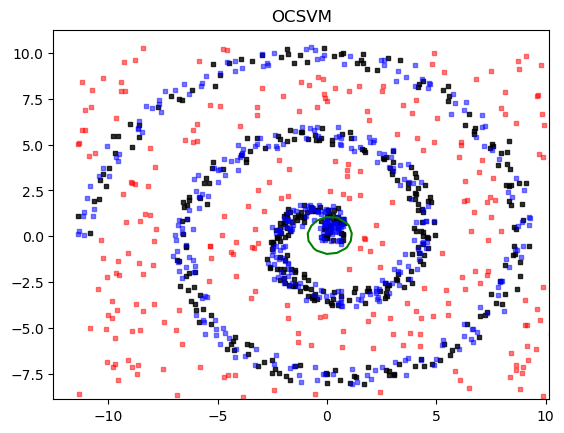

In [47]:
# OCSVM
fig, axs = plt.subplots(1,1)
num_params = num_search
sigmas = np.logspace(-2,2,num_params)
nus = np.linspace(0.01,0.99,num_params)

gridsearch = np.zeros((num_params*num_params,3)) #sigma rows, q, cols
mesh = np.zeros((num_params,num_params))
#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    j = 0
    for nu in nus:
        gamma = 0.5/(sigma*sigma)
        model = OCSVM(nu = nu, gamma = gamma)
        model.fit(x_train)
        val_scores = model.decision_function(x_val)
        auc = metrics.roc_auc_score(y_val,val_scores)
        gridsearch[run,:]= np.asarray([sigma,nu,auc])
        mesh[j,i]=auc
        run += 1
        j += 1
    i += 1

best_idx = np.argmax(gridsearch[:,2])
val_auc = np.max(gridsearch[:,2])
best_sigma = gridsearch[best_idx,0]
best_nu = gridsearch[best_idx,1]

param_heatmap(methods[3],fig,axs,sigmas,nus,mesh,'sigma','nu',best_sigma,best_nu,log=True)

gamma = 0.5/(best_sigma*best_sigma)
model = OCSVM(nu = best_nu, gamma = gamma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
print('dataset:{Circle} method:{',methods[3],'} best params:',  '{nu:',round(best_nu,4),'sigma:',round(best_sigma,4),'} val auc:', round(val_auc,4),'  test auc:',round(test_auc,4))
models.append(model)
decision_boundary_plot(x_train, x_test, y_test, [model],methods[3])


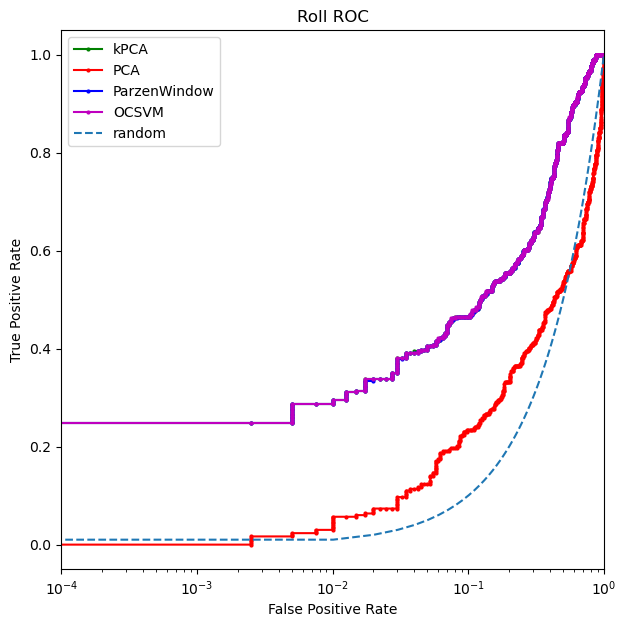

In [48]:
# ROC Curve
ROC_curve(y_test, scores, key='Roll')